# IMPORT LIBRARIES

In [74]:
pip install pmdarima

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
import pickle
# Google services
import gspread
from gspread_dataframe import set_with_dataframe
from google.oauth2.service_account import Credentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import drive
drive.mount('/content/drive')
from google.auth import default
from google.colab import auth
# Authenticate
auth.authenticate_user()
creds, _ = default()
# Authorize gspread
gc = gspread.authorize(creds)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# LOAD DATA

Số lượng vé bán ra trong tháng của 1 nhà hát qua các thời kỳ

0  Month  Sales
1      1   1580
2      2   1608
3      3   1370
4      4   1260
5      5   1125
6      6   1306
7      7   1240
8      8   1340
9      9   1090
10    10    980
11    11   1260
12    12   1680
13     1   1630
14     2   1700
15     3   1610
16     4   1590
17     5   1498
18     6   1540
19     7   1580
20     8   1680
21     9   1560
22    10   1520
23    11   1670
24    12   1920
25     1   1960
26     2   1880
27     3   1820
28     4   1750
29     5   1690
30     6   1730
31     7   1690
32     8   1780
33     9   1670
34    10   1560
35    11   1760
36    12   2040


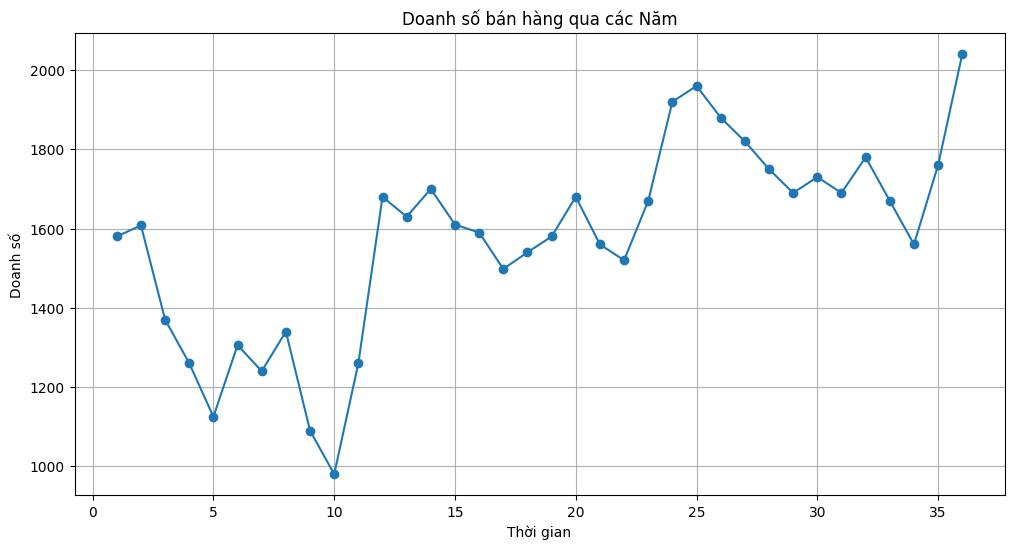

In [82]:
# Colab
spreadsheet_id = "1TRCjbkCwgM2usvYWdC_BUcYouM9nidvI-Mq-T1A--Hs"  # Replace with your Spreadsheet ID
sheet_name = "data"  # Change to your sheet name

# Open the Google Spreadsheet
sh = gc.open_by_key(spreadsheet_id)
worksheet = sh.worksheet(sheet_name)

# Get all data
data = worksheet.get_all_values()
df = pd.DataFrame(data)
df.columns = df.iloc[0]
df = df[1:]
# Rename columns and keep only Month and Sales
df = df.rename(columns={'month': 'Month', 'ticket': 'Sales'})
df = df[['Month', 'Sales']]
# Convert Month to datetime and set as index
# df['Month'] = pd.to_datetime(df['Month'],format='%Y') #format='%Y'
# Convert 'Sales' column to numeric, handling commas and extra characters
# df['Sales'] = df['Sales'].astype(str).str.replace(',', '', regex=False)
# df['Sales'] = df['Sales'].str.replace(r'[^\d.]', '', regex=True)
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')
# df.set_index('Month', inplace=True)
print(df)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(df['Sales'], marker='o', linestyle='-')
plt.title('Doanh số bán hàng qua các Năm')
plt.xlabel('Thời gian')
plt.ylabel('Doanh số')
plt.grid()
plt.show()

# INPUT

In [83]:
freq = 12 # input frequency seasonal
lags_1 = 20
lags_2 = 16

# SEASONALITY & STATIONATIRY

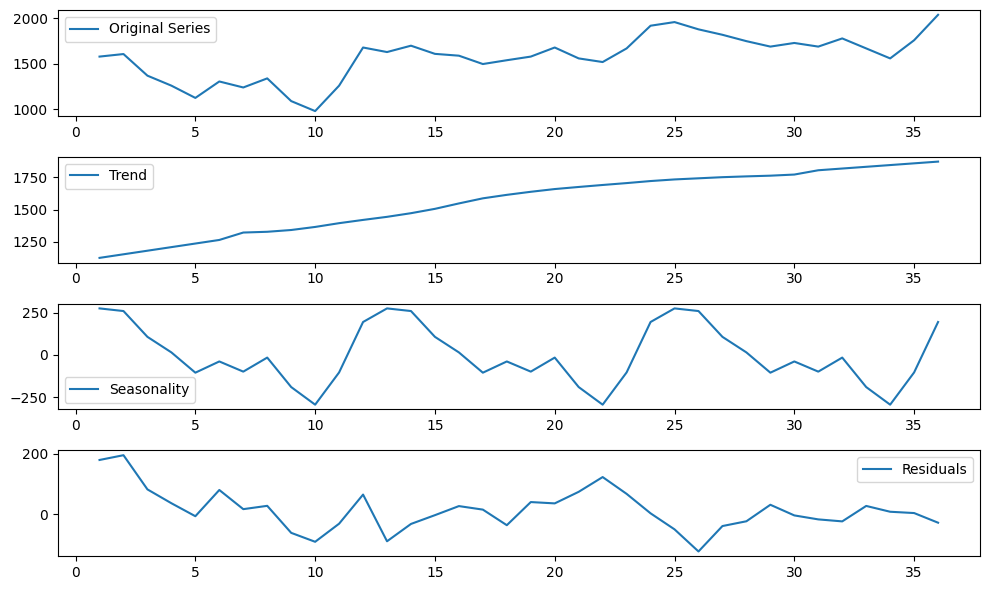

ADF Statistic: -1.557516757925966
p-value: 0.5048913660145176
Dữ liệu có tính dừng


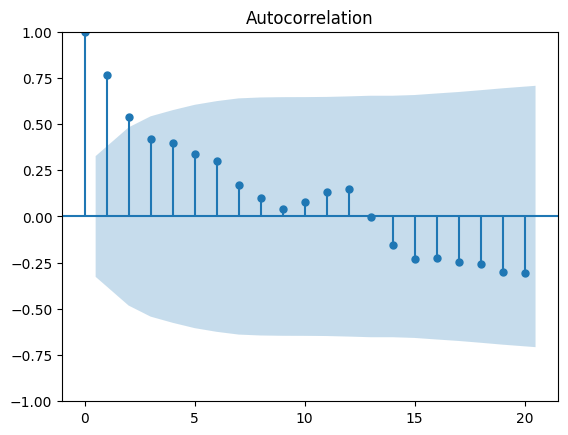

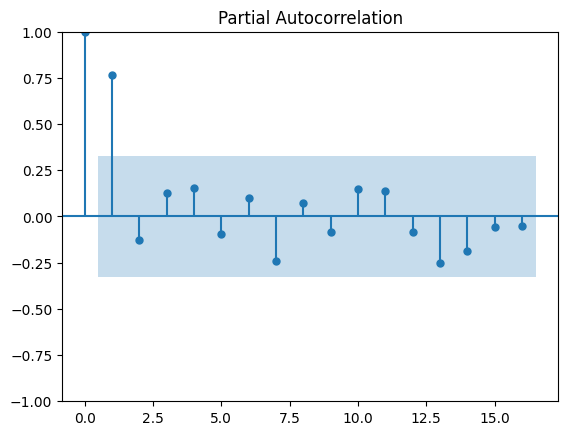

Có tính chu kỳ (seasonality_strength=0.70), nên dùng seasonal=True.
Seasonal = True


In [84]:
def check_seasonality(time_series, freq=None):
    """
    Kiểm tra xem chuỗi thời gian có tính chu kỳ không.

    Params:
        time_series: Chuỗi dữ liệu dạng pandas Series.
        freq: Tần suất chu kỳ (nếu biết trước, có thể đặt, ví dụ: 12 cho dữ liệu hàng tháng).

    Returns:
        True nếu có seasonality, False nếu không.
    """
    # Bước 1: Phân rã chuỗi thời gian (Seasonal Decomposition)
    decomposition = seasonal_decompose(time_series, period=freq, model='additive', extrapolate_trend='freq')
    seasonal_component = decomposition.seasonal

    # Vẽ thành phần chu kỳ
    plt.figure(figsize=(10, 6))
    plt.subplot(411)
    plt.plot(time_series, label='Original Series')
    plt.legend()
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()
    plt.subplot(413)
    plt.plot(seasonal_component, label='Seasonality')
    plt.legend()
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Bước 2: Kiểm tra ADF Test (Stationarity Test)
    adf_result = adfuller(time_series.dropna())
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")

    if adf_result[1] > 0.05:
        print("Dữ liệu có tính dừng")
    else:
        print("Dữ liệu không có tính dừng")

    # Bước 3: Kiểm tra Auto-Correlation Function (ACF)
    plot_acf(time_series.dropna(), lags=lags_1)
    plt.show()

    plot_pacf(time_series.dropna(), lags=lags_2)
    plt.show()

    # Bước 4: Đánh giá độ biến động của thành phần chu kỳ
    seasonality_strength = np.std(seasonal_component) / np.std(time_series)

    if seasonality_strength > 0.1:
        print(f"Có tính chu kỳ (seasonality_strength={seasonality_strength:.2f}), nên dùng seasonal=True.")
        return True
    else:
        print(f"Không có tính chu kỳ rõ ràng (seasonality_strength={seasonality_strength:.2f}), nên dùng seasonal=False.")
        return False

# Kiểm tra seasonality
should_use_seasonal = check_seasonality(df['Sales'], freq=freq) # freq=freq
print(f"Seasonal = {should_use_seasonal}")

# BUILDING AN ARIMA MODEL

## Automatically select the best parameters using auto_arima:
auto_arima sẽ tự xử lý differencing nếu dữ liệu có stationarity = false

In [85]:
# Dùng auto_arima để chọn tham số
if should_use_seasonal == True:
  model_auto = auto_arima(df['Sales'], seasonal=True, m=freq, trace=True, suppress_warnings=True, stepwise=True)
else:
  model_auto = auto_arima(df['Sales'], seasonal=False, trace=True, suppress_warnings=True, stepwise=True)

print(model_auto.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=453.327, Time=0.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=433.893, Time=0.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=447.461, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=451.600, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=454.302, Time=0.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=433.035, Time=0.43 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=447.719, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=435.035, Time=0.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=435.035, Time=0.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.51 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=431.047, Time=0.29 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=446.554, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=431.911, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=433.047, Time=0.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=433.047, Time=0.46 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.69 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=433.033, Time=0.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.68 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[12]             : AIC=429.114, Time=0.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,1)[12]             : AIC=444.643, Time=0.32 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=429.932, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,1)[12]             : AIC=inf, Time=0.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,2)[12]             : AIC=431.114, Time=0.32 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,2)[12]             : AIC=inf, Time=0.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,0)[12]             : AIC=inf, Time=0.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,2)[12]             : AIC=433.114, Time=1.85 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12]             : AIC=431.104, Time=1.41 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12]             : AIC=431.103, Time=0.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(0,1,0)(1,0,1)[12]          
Total fit time: 16.586 seconds
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   36
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -211.557
Date:                              Wed, 19 Feb 2025   AIC                            429.114
Time:                                      04:34:47   BIC                            433.780
Sample:                                           0   HQIC                           430.725
                                               - 36                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

## Training ARIMA model:

In [86]:
# Xây dựng mô hình với tham số từ auto_arima
if should_use_seasonal == True:
  model = SARIMAX(df['Sales'], order=model_auto.order, seasonal_order=model_auto.seasonal_order)
  model_fit = model.fit()
else:
  model = ARIMA(df['Sales'], order=model_auto.order)
  model_fit = model.fit()

# Tóm tắt kết quả mô hình
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                      SARIMAX Results                                       
Dep. Variable:                                Sales   No. Observations:                   36
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -211.557
Date:                              Wed, 19 Feb 2025   AIC                            429.114
Time:                                      04:34:47   BIC                            433.780
Sample:                                           0   HQIC                           430.725
                                               - 36                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9832      0.150      6.551      0.000       0.689       1.277
ma.S.L12      -0.67

# FORECAST AND ASSESSMENT

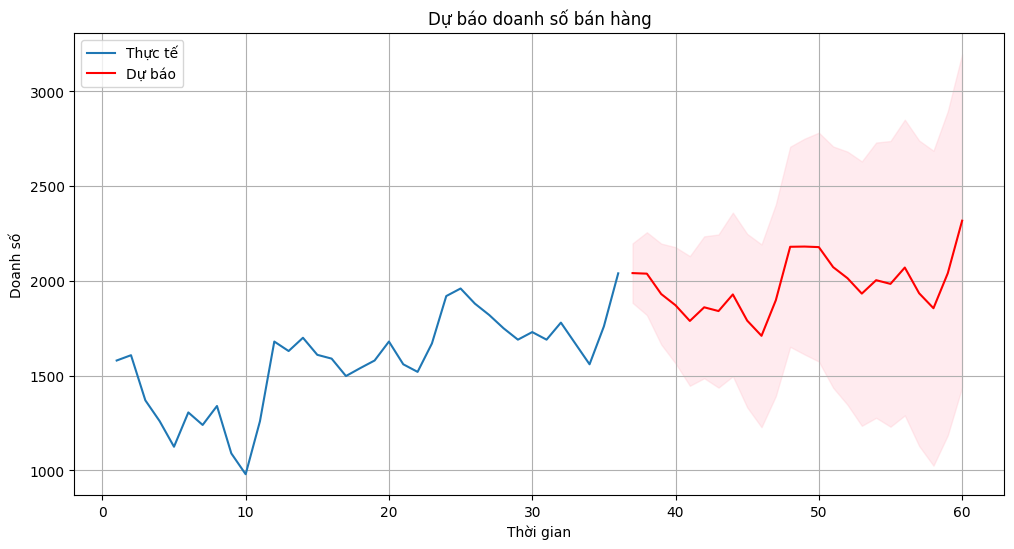

       Forecast  Lower Bound  Upper Bound
37  2041.211246  1884.387939  2198.034553
38  2038.281058  1819.896216  2256.665900
39  1930.761668  1664.697147  2196.826188
40  1871.404246  1564.991585  2177.816907
41  1788.778174  1446.744392  2130.811957
42  1860.767958  1486.487985  2235.047930
43  1840.966418  1437.006163  2244.926673
44  1928.551455  1496.947148  2360.155761
45  1790.546417  1332.965094  2248.127740
46  1710.333058  1228.172238  2192.493878
47  1898.338990  1392.792309  2403.885670
48  2180.056273  1652.158711  2707.953835
49  2181.247188  1612.242649  2750.251727
50  2178.366183  1574.651865  2782.080500
51  2072.651483  1436.117282  2709.185684
52  2014.290363  1346.547448  2682.033278
53  1933.051153  1235.494408  2630.607898
54  2003.832603  1277.685080  2729.980125
55  1984.363427  1230.708974  2738.017881
56  2070.478368  1290.286182  2850.670554
57  1934.789716  1128.933241  2740.646192
58  1855.922721  1025.194444  2686.650999
59  2040.773013  1185.896248  2895

In [108]:
# Dự báo cho tương lai (24 tháng tiếp theo)
forecast = model_fit.get_forecast(steps=25)
# forecast_index = pd.date_range(df.index[-1], periods=12, freq='YS')  #freq='M' last day of monthly, 'MS' first day of monthly, 'YS' yearly
forecast_index = np.arange(len(df)+1, len(df) + 25)

forecast_df = pd.DataFrame({
    'Forecast': forecast.predicted_mean,
    'Lower Bound': forecast.conf_int()['lower Sales'],
    'Upper Bound': forecast.conf_int()['upper Sales']
}, index=forecast_index)

# Vẽ biểu đồ dự báo
plt.figure(figsize=(12, 6))
plt.plot(df['Sales'], label='Thực tế')
plt.plot(forecast_df['Forecast'], label='Dự báo', color='red')
plt.fill_between(forecast_df.index,
                 forecast_df['Lower Bound'],
                 forecast_df['Upper Bound'], color='pink', alpha=0.3)
plt.title('Dự báo doanh số bán hàng')
plt.xlabel('Thời gian')
plt.ylabel('Doanh số')
plt.legend()
plt.grid()
plt.show()

print(forecast_df)

# MODEL EVALUATION

In [109]:
# Tính toán MAE và RMSE
actual_values = df['Sales'][-12:-1]  # Exclude the last point
forecast_values = forecast_df['Forecast'][1:12]  # Skip first forecast and take next 11 values

mae = mean_absolute_error(actual_values, forecast_values)
rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 140.79870129104566
RMSE: 191.61784384943027


# MODEL DEPLOYMENT

In [110]:
# Lưu mô hình
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(model_fit, f)

# Tải lại mô hình khi cần
with open('arima_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Dự báo lại với mô hình đã lưu
forecast_loaded = loaded_model.get_forecast(steps=12)
print(forecast_loaded.predicted_mean)

37    2041.211246
38    2038.281058
39    1930.761668
40    1871.404246
41    1788.778174
42    1860.767958
43    1840.966418
44    1928.551455
45    1790.546417
46    1710.333058
47    1898.338990
48    2180.056273
Name: predicted_mean, dtype: float64


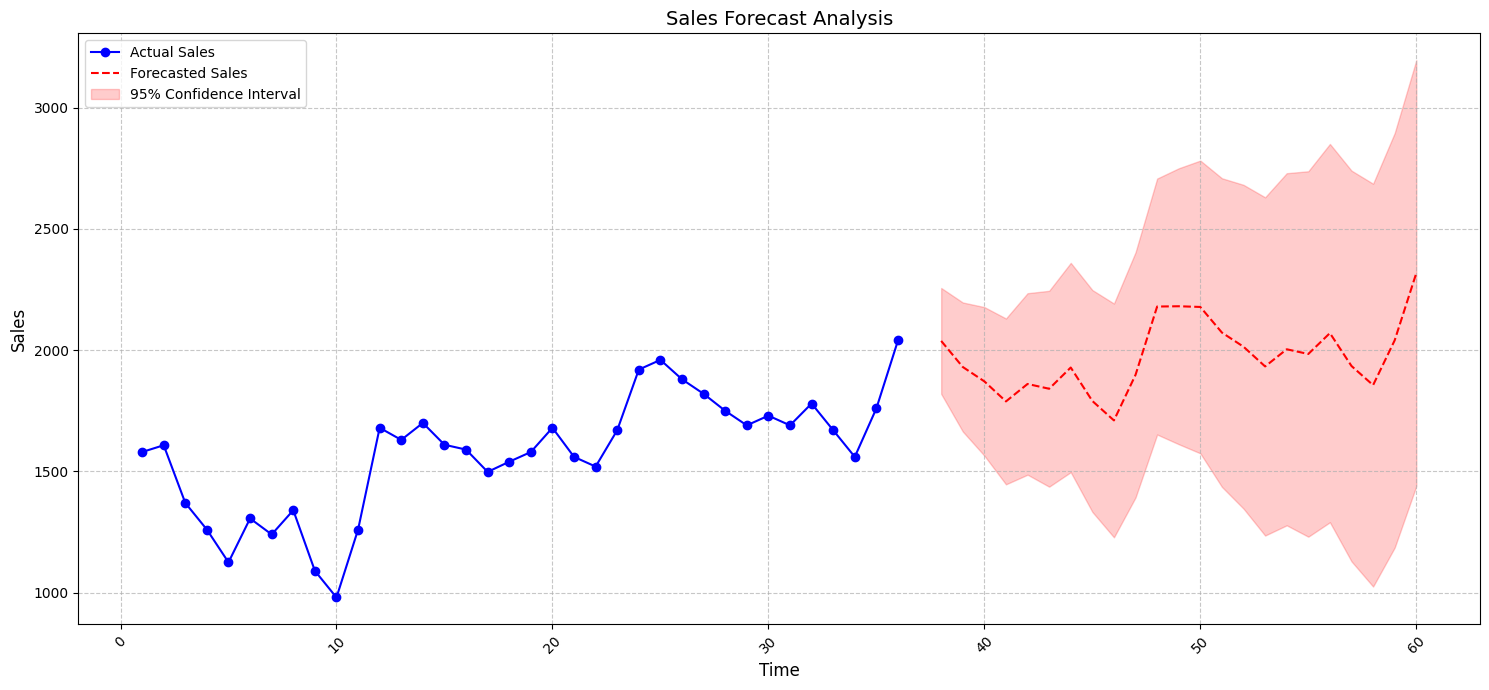

In [111]:
plt.figure(figsize=(15, 7))

# Plot actual values
plt.plot(df.index, df['Sales'], label='Actual Sales', color='blue', marker='o')

# Plot forecasted values
plt.plot(forecast_df.index[1:], forecast_df['Forecast'][1:], label='Forecasted Sales', color='red', linestyle='--')

# Add confidence intervals
plt.fill_between(forecast_df.index[1:],
         forecast_df['Lower Bound'][1:],
         forecast_df['Upper Bound'][1:],
         color='red', alpha=0.2, label='95% Confidence Interval')

plt.title('Sales Forecast Analysis', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()